In [32]:
from IPython.display import Audio
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import os
import librosa
import librosa.display
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imsave
%matplotlib inline

In [29]:
data = np.load('gtzan/no_genres_melSpec64x14400_22050hz_np/blues.00001.npy')

print(data.shape)

window_size = 64
k = 3
tensor = tensor=tf.image.random_crop(data, size=[64, window_size*k])


# tensor = tf.reshape(tensor=tf.image.random_crop(data, size=[window_size*k]), 
#                     shape=(1, k, window_size, 1))

(64, 14400)
2250.0


# Mel_spec extraction

In [33]:
# ----------Params--------------------------------
# set paths
orig_data_path = 'gtzan/no_genres/'
save_data_path = 'gtzan/no_genres_melSpec64x14400_22050hz_np'
save_img = True
save_image_path = 'gtzan/no_genres_melSpec64x14400_22050hz_img'

# set mel encoding
n_fft = 2048  # standart for mel_spectograms of audio data
n_mels = 64

# set dimensions based on cpc training arguments
T = 27 # samples (not seconds)
k = 3 # samples (not seconds)
audio_length = 30 # in seconds (entire audio file)
cpc_length = 4 # in seconds (length of T+k in sec)

# create dirs
if not os.path.isdir(save_data_path):
    os.mkdir(save_data_path)
if not os.path.isdir(save_image_path):
    os.mkdir(save_image_path)

# ----------Encode audio files----------------------
audio_fns = os.listdir(orig_data_path)
audio_paths = [os.path.join(orig_data_path, fn) for fn in audio_fns]
save_fns = [os.path.splitext(audio_fn)[0] for audio_fn in audio_fns]
n_files = len(audio_paths)

# calculate suiting hop length
samples_per_cpc_timestep = n_mels # when equal to n_mels, will produce square images for encoder input
samples_per_cpc_audio = (T+k) * samples_per_cpc_timestep # amount of samples per cpc_audio
samples_per_audio_file = int(samples_per_cpc_audio / cpc_length * audio_length) # amount of samples per audio file
_, orig_sr = librosa.load(audio_paths[0]) # get sr_rate for calculation of the hop size
hop_length = int(orig_sr*audio_length // samples_per_audio_file)

for i, audio_path in enumerate(audio_paths):
    if i % 100 == 0:
        print(f'[INFO] - {i/n_files*100:0.2f}% finished')

    # load audio_data
    audio_binary = tf.io.read_file(audio_path)
    audio_file, sr = tf.audio.decode_wav(audio_binary,
                                         desired_channels=1,
                                         desired_samples=orig_sr*audio_length)
    audio_file = np.squeeze(audio_file.numpy())

    # convert audio to mel_spectrogram
    audio_file = librosa.feature.melspectrogram(audio_file,
                                                sr=sr,
                                                n_fft=n_fft,
                                                hop_length=hop_length,
                                                n_mels=n_mels)
    # convert power spec (amplitude squared) to decibels ('log scale' of amplitudes)
    audio_file_DB = librosa.power_to_db(audio_file,
                                        ref=np.min)
    
    # save the mel_spec and if desired an image of it
    orig_audio_fn = os.path.splitext(audio_path.split('/')[-1])[0]
    data_save_path = os.path.join(save_data_path, orig_audio_fn)
    np.save(data_save_path, audio_file_DB[:, :samples_per_audio_file])
    
    if save_img:
        save_fn = orig_audio_fn + '.jpeg'
        save_path = os.path.join(save_image_path, save_fn)
        imsave(save_path, audio_file_DB[:, :samples_per_audio_file])

    del audio_file, audio_file_DB, audio_binary

[INFO] - 0.00% finished
[INFO] - 10.00% finished
[INFO] - 20.00% finished
[INFO] - 30.00% finished
[INFO] - 40.00% finished
[INFO] - 50.00% finished
[INFO] - 60.00% finished
[INFO] - 70.00% finished
[INFO] - 80.00% finished
[INFO] - 90.00% finished


# Visualization (mel_spec, PCA, tSNE)

## Mel_specs

(64, 14400) 1920.0


/home/janosch/.miniconda3/envs/tf_2.4/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/janosch/.miniconda3/envs/tf_2.4/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


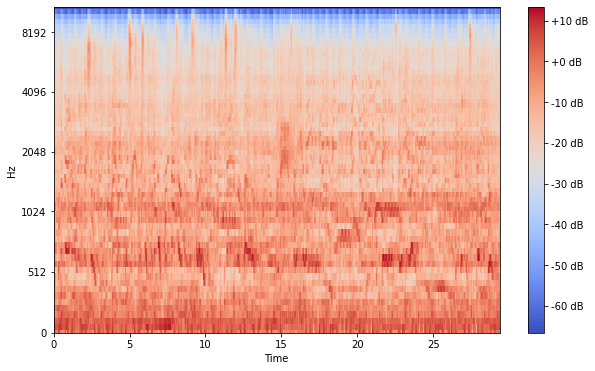

In [6]:
data_path = 'gtzan/no_genres/'
# for data preprocessing (data_genertator) time resolution must be evenly divideble
hop_length = 45  # 344
n_mels = 64  # by desired_audio_length time_res%desired_audio_length == 0
n_fft = 4096  # 2048

desired_audio_length = 30  # entire audio_file
audio_fns = os.listdir(data_path)
audio_paths = [os.path.join(data_path, fn) for fn in audio_fns]

audio_file, sr = librosa.load(audio_paths[20], sr=None)
Audio(audio_file, rate=sr)

audio_file = librosa.feature.melspectrogram(
    audio_file, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
audio_file_DB = librosa.power_to_db(audio_file, ref=np.std)[:, :14400]
print(audio_file_DB.shape, audio_file_DB[:, :14400].shape[1]/30*4)

plt.figure(figsize=(10, 6))
librosa.display.specshow(
    audio_file_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.show()

In [ ]:
data_path = 'gtzan/no_genres/'
# for data preprocessing (data_genertator) time resolution must be evenly divideble
hop_length = 344
n_mels = 64  # by desired_audio_length time_res%desired_audio_length == 0
n_fft = 2048

desired_audio_length = 30  # entire audio_file
save_img = False

audio_fns = os.listdir(data_path)
audio_paths = [os.path.join(data_path, fn) for fn in audio_fns]

audio_file, sr = librosa.load(audio_paths[0], sr=None)
Audio(audio_file, rate=sr)

audio_file = librosa.feature.melspectrogram(
    audio_file, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
audio_file_DB = librosa.power_to_db(audio_file, ref=np.max)[:, :3840]
print(audio_file_DB.shape, audio_file_DB.shape[1]/30)

plt.figure(figsize=(10, 6))
librosa.display.specshow(
    audio_file_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.show()

print('max before', audio_file_DB.max())
print('min before', audio_file_DB.min())


# standardization
mean = np.mean(audio_file_DB, axis=-1, keepdims=True)
std = np.std(audio_file_DB, axis=-1, keepdims=True)

import scipy
audio_file_DB = (audio_file_DB-mean)/std
audio_file_DB = scipy.ndimage.gaussian_filter1d(audio_file_DB, sigma=4, axis=1)

plt.figure(figsize=(10, 6))
librosa.display.specshow(
    audio_file_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.show()

print('max', audio_file_DB.max())
print('min', audio_file_DB.min())

#min max

# a = tf.constant(-1, dtype=tf.float32)
# b = tf.constant(1, dtype=tf.float32)
# min = tf.math.reduce_min(audio_file_DB, axis=None)
# max = tf.math.reduce_max(audio_file_DB, axis=None)
# audio_file_DB = (a + ((audio_file_DB-min)*(b-a)/max-min)).numpy()

audio_file_DB = tf.squeeze(tf.image.per_image_standardization(tf.expand_dims(audio_file_DB, axis=-1))).numpy()

print('max', audio_file_DB.max())
print('min', audio_file_DB.min())

plt.figure(figsize=(10, 6))
librosa.display.specshow(
    audio_file_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.show()


## tSNE

In [ ]:
ls 

In [ ]:
data_path = 'fma/fma_small_mono_wav'
audio_fns = [fn.rsplit('.', 1)[0] for fn in os.listdir(data_path)]
audio_fns.sort()

data_meta_path = 'fma/fma_metadata/tracks.csv'
data_meta = pd.read_csv(data_meta_path).to_numpy()
data_labels = data_meta[:, [6, 40]]

print(data_meta[0, :])

In [ ]:
small = tracks[tracks['set', 'subset'] <= 'small']
small.shape

In [ ]:
audio_labels = []
for fn in audio_fns:
    print(np.where(data_labels[:, 0] == int(fn)))

In [ ]:
for r in data_labels[2:]:
    r[0] = int(r[0])

print(data_labels)

In [ ]:
data_path = 'fma/fmaSmall_melSpec64x1920_22050hz_np/'
mel_spec_fns = os.listdir(data_path)
mel_spec_paths = [os.path.join(data_path, fn) for fn in mel_spec_fns]
fma_data = np.array([np.load(mel_spec)
                    for mel_spec in mel_spec_paths]).reshape((7997, -1))

tsne_data = TSNE(n_components=2).fit_transform(fma_data)
plt.figure(figsize=(10, 7.5))

tsne_plot_AE = sns.scatterplot(x=tsne_data[:, 0],
                               y=tsne_data[:, 1])

# tsne_plot_AE.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
tsne_plot_AE.set_title('TSNE of fma', fontdict={'fontsize': 25})

plt.show()

## PCA

In [ ]:
tsne_data = PCA(n_components=2).fit_transform(cp_gtzan_data)
plt.figure(figsize=(10, 7.5))
tsne_plot_AE = sns.scatterplot(x=tsne_data[:, 0],
                               y=tsne_data[:, 1],
                               hue=gtzan_labels[:, 0],
                               palette=['purple', 'red', 'orange', 'brown', 'blue',
                                        'dodgerblue', 'green', 'lightgreen', 'darkcyan', 'black'],
                               legend='full')

tsne_plot_AE.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
tsne_plot_AE.set_title(
    'PCA of gtzan features (no standardization)', fontdict={'fontsize': 25})

plt.show()

In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa

In [ ]:
outputs = np.random.randint(low=0, high=100, size=(5,5))
print(outputs)
tfa.image.gaussian_filter2d(outputs, filter_shape=(0,4), sigma=4)
